In [1]:
aid = None
print(f'aid={aid}')

aid=None


In [2]:
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from captum.attr import visualization as viz

import numpy as np
import scipy
from scipy.linalg import orth

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import random

from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

# our own imports
import util
from util import compute_tangent_space, project_into_tangent_space, normalize_image, dcn

from models import lenet_model_and_optimizer

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [4]:
IMG_DIM = 32

#### convert papermill parameter to the actual notebook parameters

In [3]:
from itertools import product

# space of all parametrizations
all_methods = ['input_times_grad', 'random', 'grad', 'int_grad', 'smoothgrad', 'tangent_space'] # 'grad_tangent_space', 'grad_not_tangent_space'
all_remove_fractions = list(np.arange(0, 1, 0.05))
all_top_or_bottom = [0, 1] # 0 is bottom, 1 is top

all_parameter_combinations = list(product(all_methods, all_remove_fractions, all_top_or_bottom))
print(len(all_parameter_combinations))

# select choosen parametrization
method = all_parameter_combinations[aid if aid is not None else 0][0]
remove_fraction = all_parameter_combinations[aid if aid is not None else 0][1]
top_or_bottom = all_parameter_combinations[aid if aid is not None else 0][2]
print(method, remove_fraction, top_or_bottom)

240
input_times_grad 0.0 0


## Load a fixed batch of data on which we evaluate the model during training

In [6]:
z_monitor, x_monitor, c_monitor, t_monitor = pkl.load(open('./output/mnist_monitor_32_10000.pkl', 'rb'))

## Load the trained model

In [7]:
def model_and_optimizer():
    return lenet_model_and_optimizer(lr=1e-3)

In [8]:
model, _ = model_and_optimizer()
model.load_state_dict(torch.load('./models/mnist32_lenet.pth'))
model.to(device)
model.eval()

MNIST32Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## What do we set 'removed' pixels to: channel mean versus black pixel

In [17]:
#channel_mean = x_monitor.flatten().mean()
#removed_pixel_value = channel_mean

In [9]:
removed_pixel_value = 0

## Visualize removing the top/bottom tangent space pixels

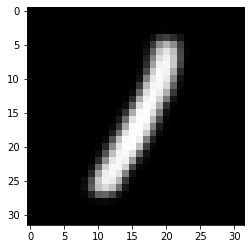

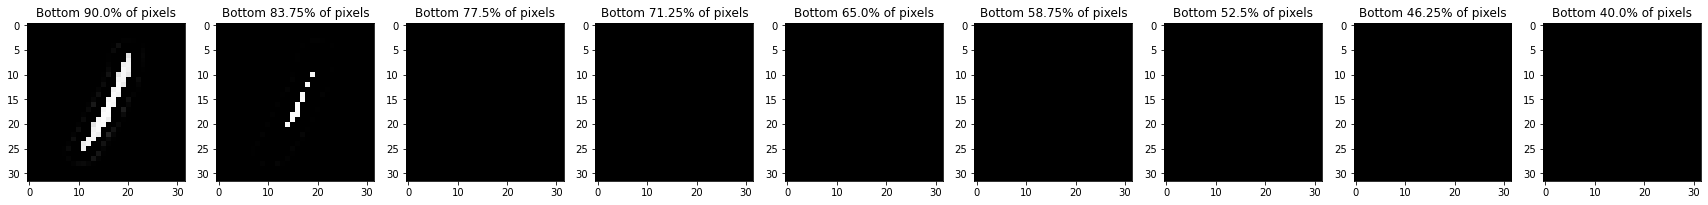

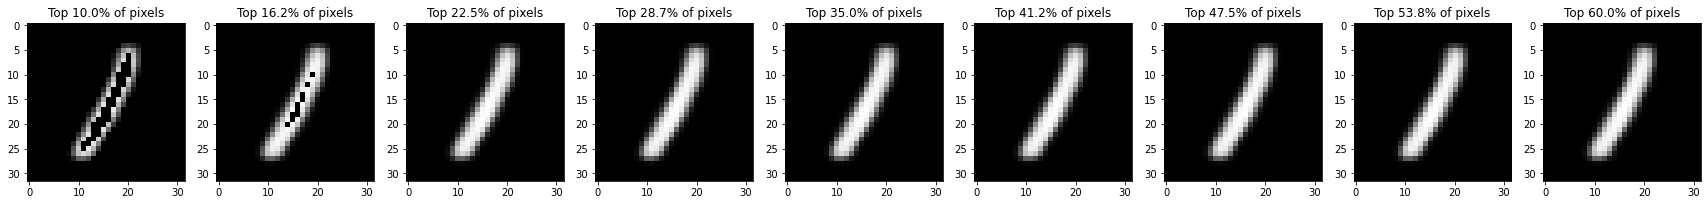

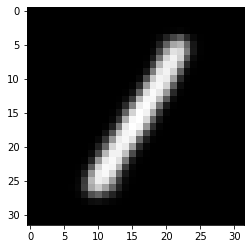

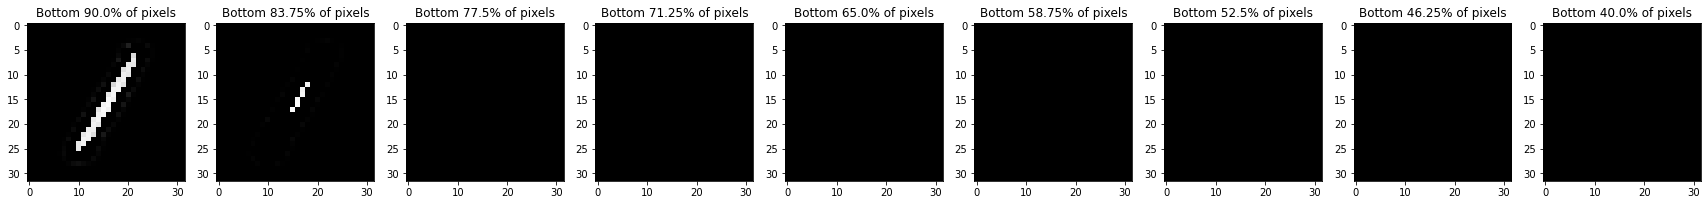

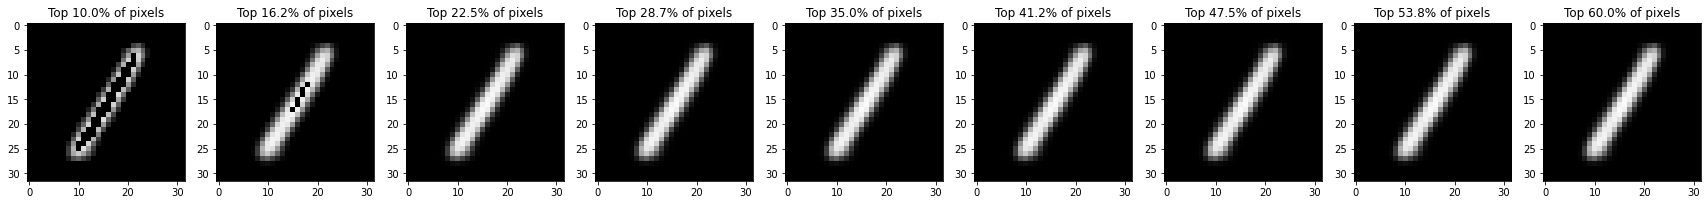

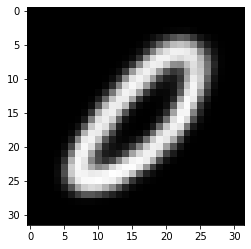

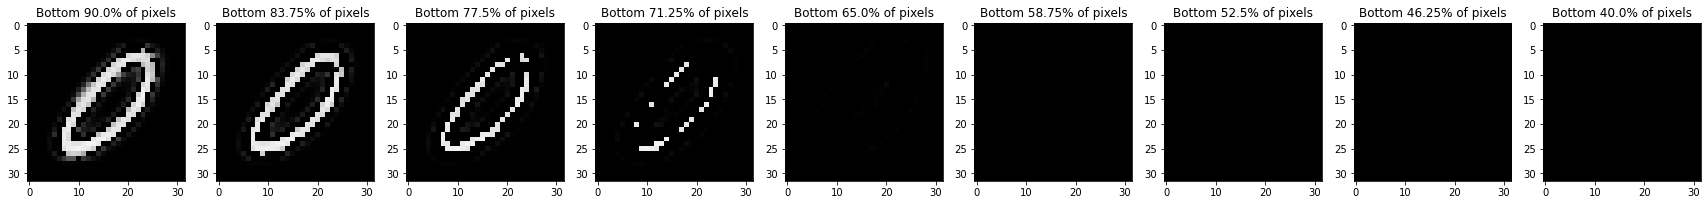

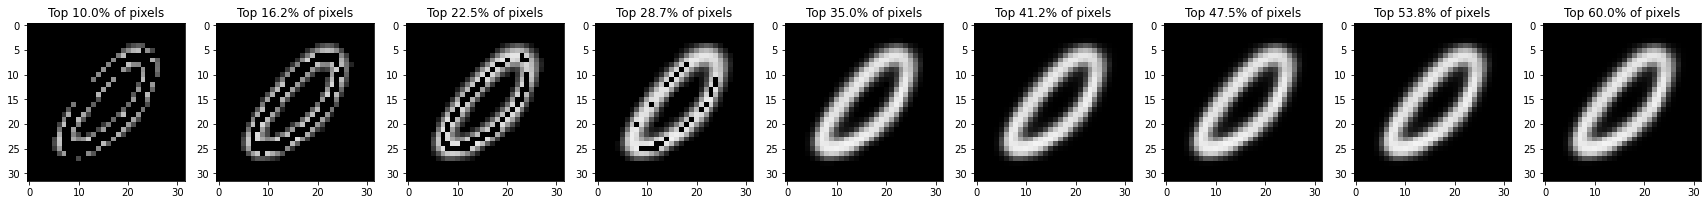

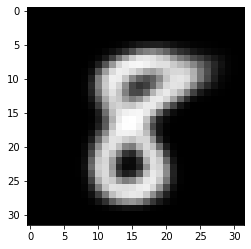

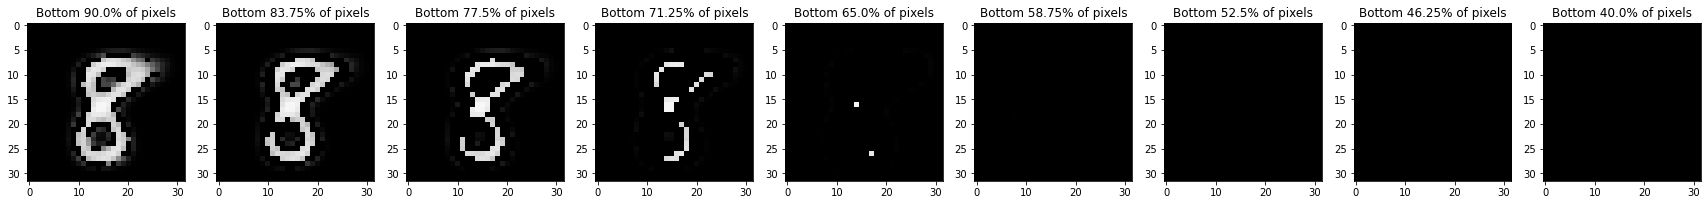

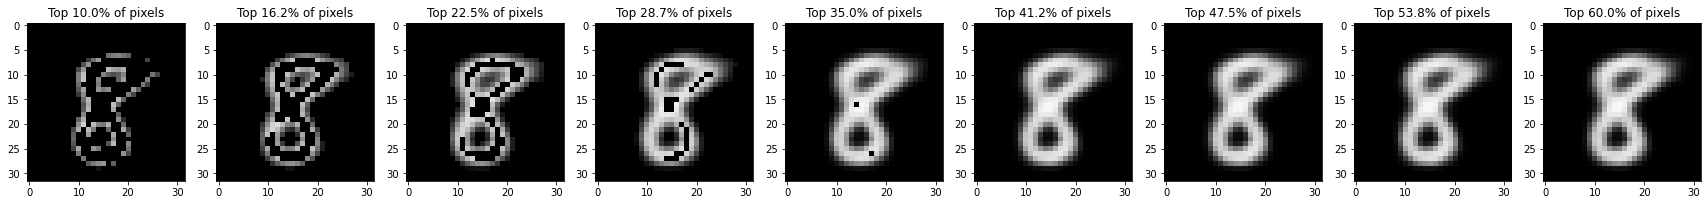

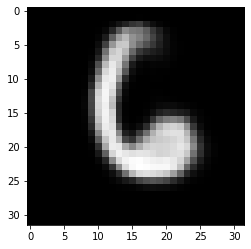

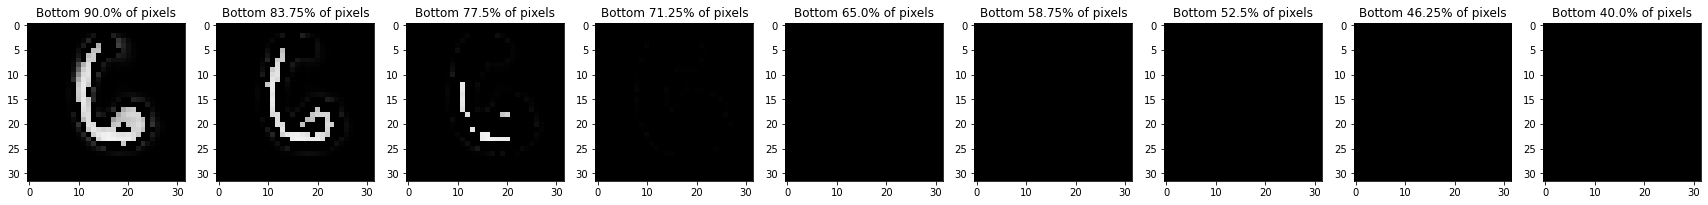

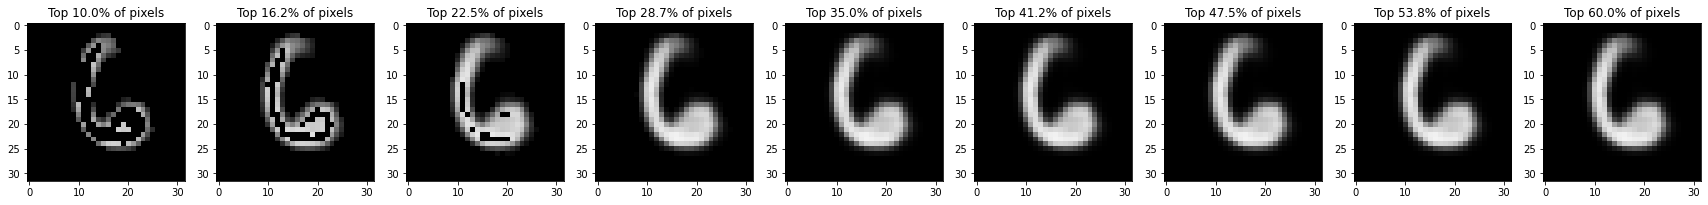

In [32]:
for i_img in range(5):
    img = np.copy(x_monitor[i_img, 0, :, :])
    tangent_space_per_pixel = util.tangent_space_per_pixel(t_monitor[i_img])
    assert np.abs(tangent_space_per_pixel.sum() - 10) < 1e-4 # consistency check: should be numerically equal to the dimension of the tangent space
    
    # show original image
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.show()
    
    # keep the bottom x% of pixels
    fig, ax = plt.subplots(1, 9, figsize=(30, 300))
    for idx, q in enumerate(np.linspace(0.9, 0.4, 9)):
        cutoff = np.quantile(tangent_space_per_pixel.flatten(), q)
        img[tangent_space_per_pixel > cutoff] = removed_pixel_value
        ax[idx].imshow(img, cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax[idx].set_title(f'Bottom {q*100}% of pixels')
    plt.show()
    
    # keep the top x% of pixels
    fig, ax = plt.subplots(1, 9, figsize=(30, 300))
    for idx, q in enumerate(np.linspace(0.9, 0.4, 9)):
        cutoff = np.quantile(tangent_space_per_pixel.flatten(), q)
        img = np.copy(x_monitor[i_img, 0, :, :])
        img[tangent_space_per_pixel <= cutoff] = removed_pixel_value
        ax[idx].imshow(img, cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax[idx].set_title(f'Top {(1-q)*100:0.1f}% of pixels')
    plt.show()

## Visualize removing the top/bottom pixels of the gradient / integrated gradients / input times gradient

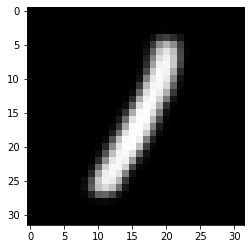

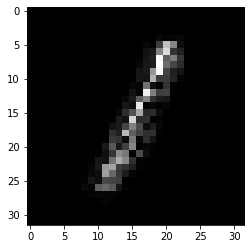

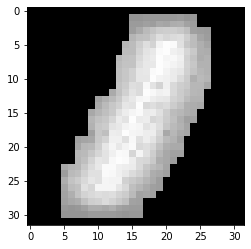

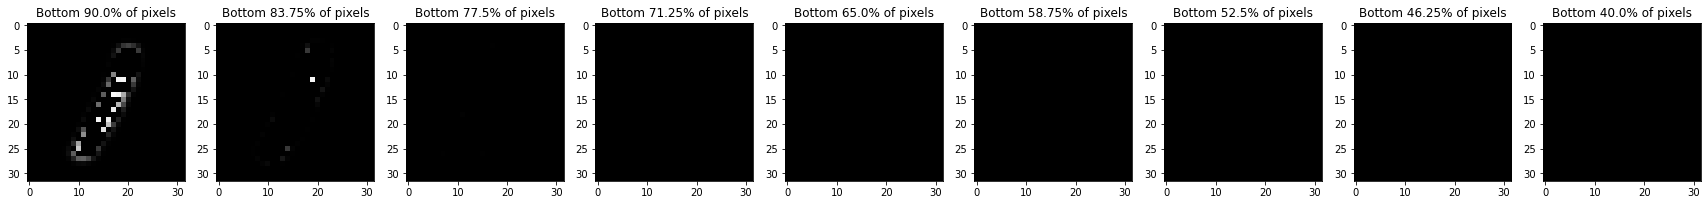

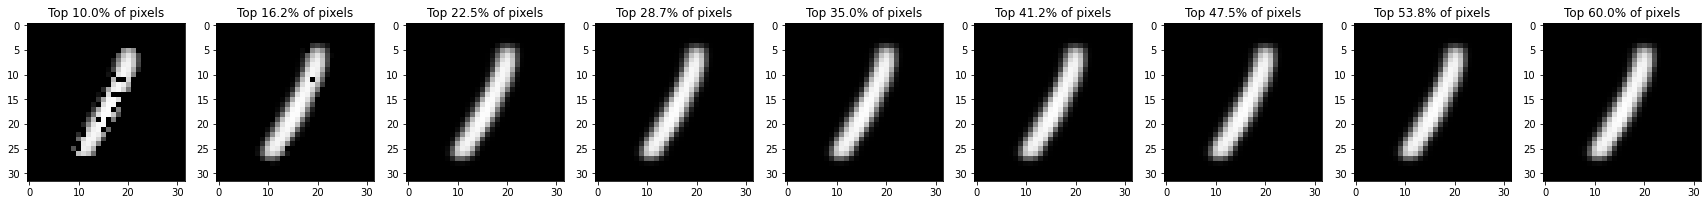

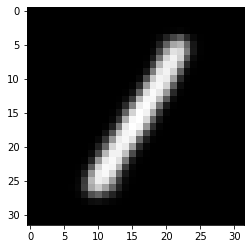

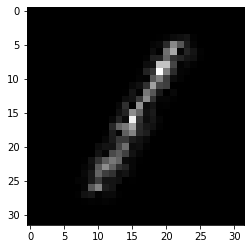

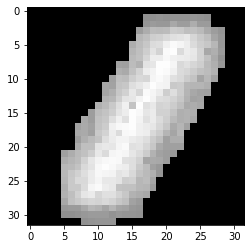

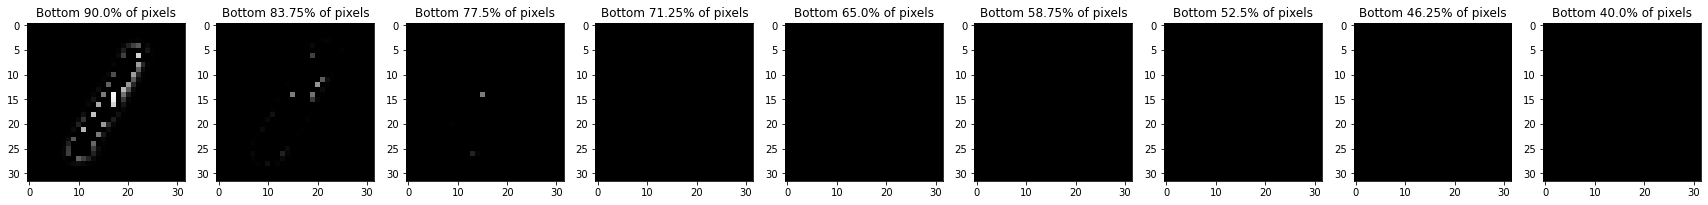

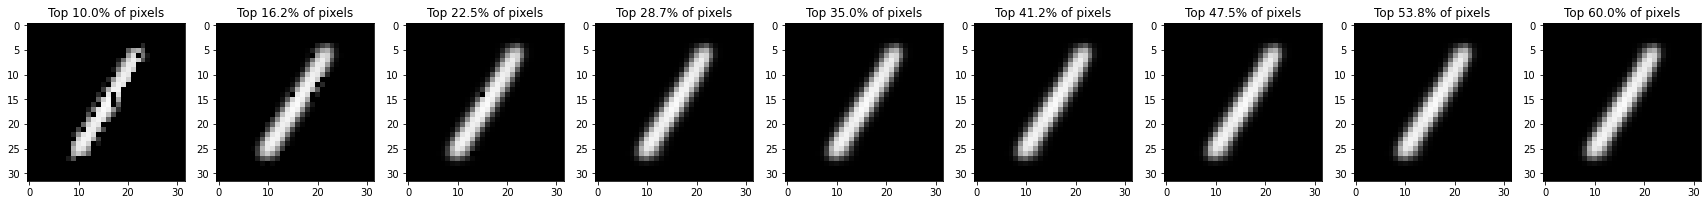

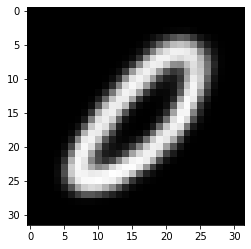

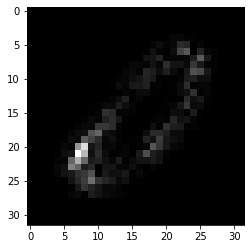

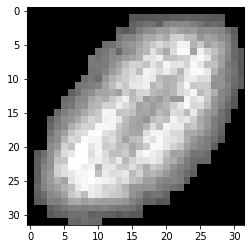

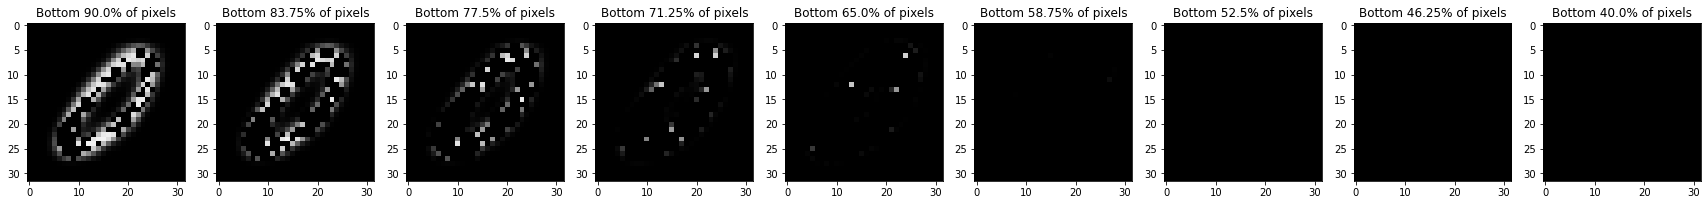

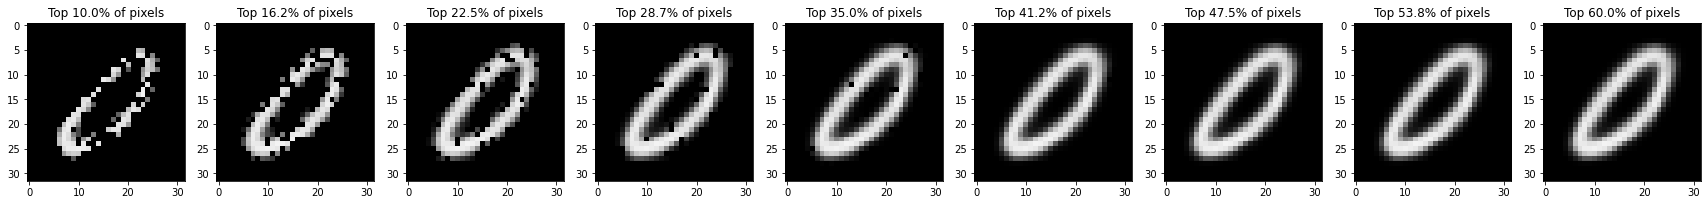

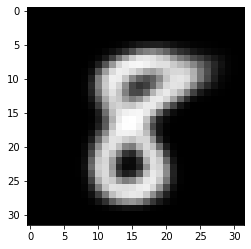

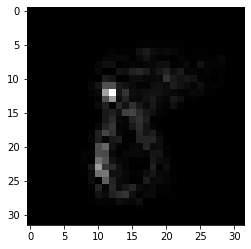

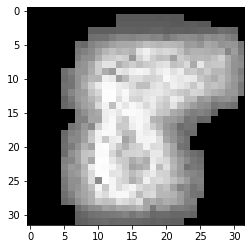

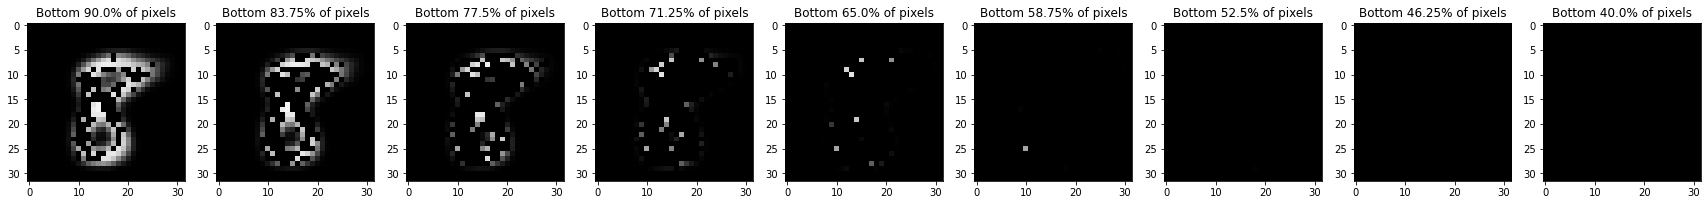

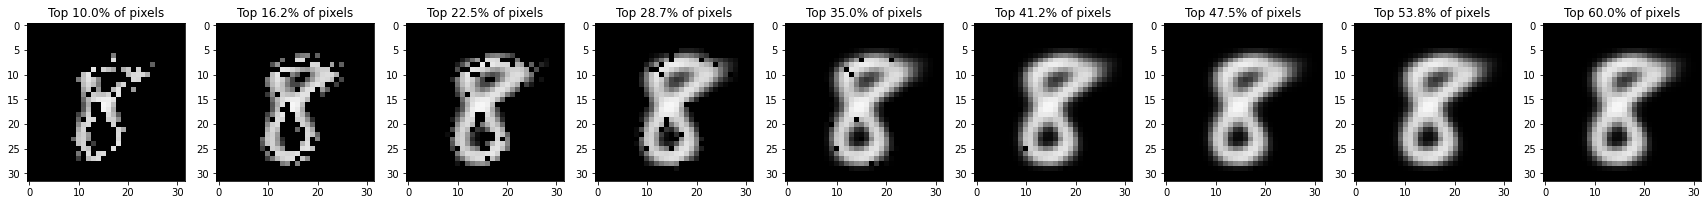

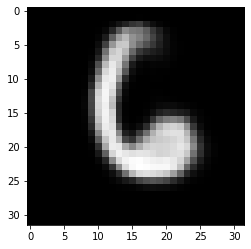

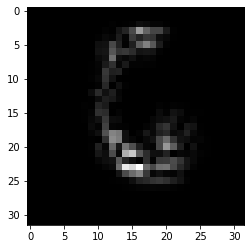

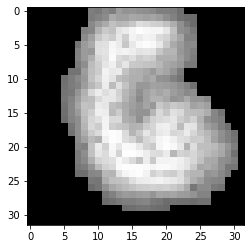

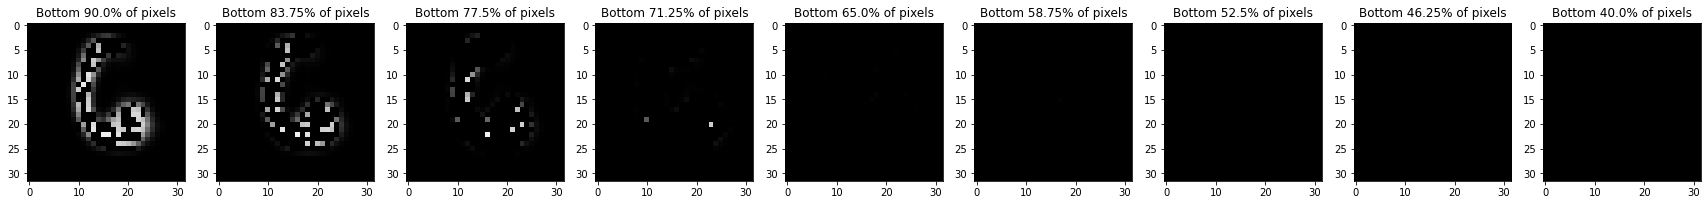

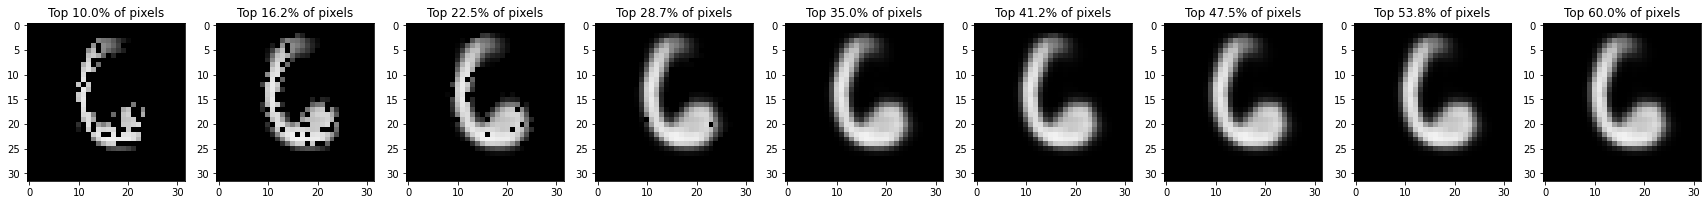

In [31]:
for i_img in range(5):
    img = np.copy(x_monitor[i_img, 0, :, :])
    
    #saliency = util.plain_gradient(model, torch.Tensor(img)) 
    #saliency = util.integrated_gradients(model, torch.Tensor(img))
    saliency = util.input_x_gradient(model, torch.Tensor(img))
    #saliency = util.smooth_grad(model, torch.Tensor(img))
    saliency = np.abs(saliency)
    
    # show original image
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.show()
    
    # plot the absolute saliency map
    plt.imshow(saliency/np.max(saliency), cmap='gray', interpolation='none', vmin=0, vmax=1)
    plt.show()
    
    # plot the quantiles of the absolute saliency map
    x = np.zeros_like(saliency)
    for idx, q in enumerate(np.linspace(0, 1, 100)):
        quantile = np.quantile(saliency.flatten(), q)
        x[saliency > quantile] = q
    plt.imshow(x, cmap='gray', interpolation='none', vmin=0, vmax=1)
    plt.show()
    
    # keep the bottom x% of pixels
    fig, ax = plt.subplots(1, 9, figsize=(30, 300))
    for idx, q in enumerate(np.linspace(0.9, 0.4, 9)):
        quantile = np.quantile(saliency.flatten(), q)
        img[saliency > quantile]  = removed_pixel_value
        ax[idx].imshow(img, cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax[idx].set_title(f'Bottom {q*100}% of pixels')
    plt.show()
    
    # keep the top x% of pixels
    fig, ax = plt.subplots(1, 9, figsize=(30, 300))
    for idx, q in enumerate(np.linspace(0.9, 0.4, 9)):
        quantile = np.quantile(saliency.flatten(), q)
        img = np.copy(x_monitor[i_img, 0, :, :])
        img[saliency <= quantile] = removed_pixel_value
        ax[idx].imshow(img, cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax[idx].set_title(f'Top {(1-q)*100:0.1f}% of pixels')
    plt.show()

## Visualize removing random pixels

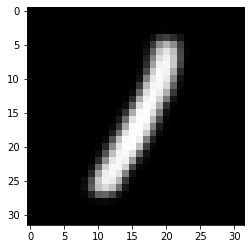

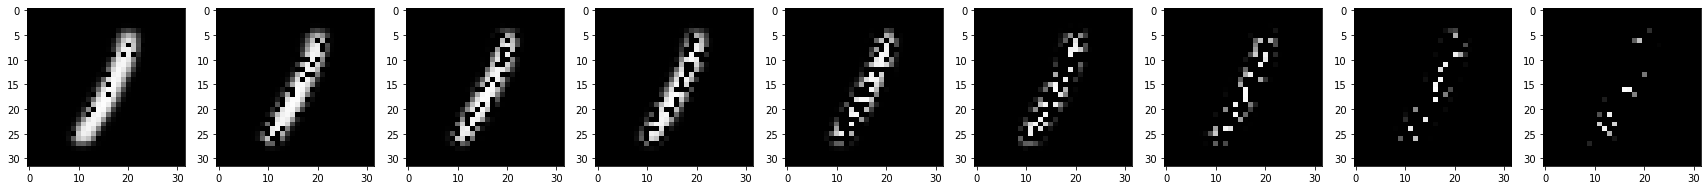

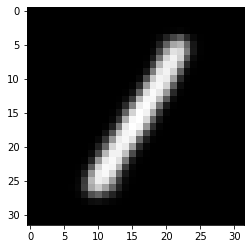

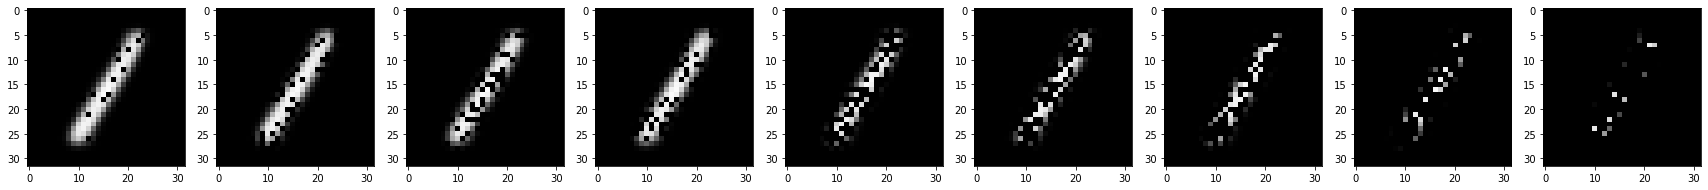

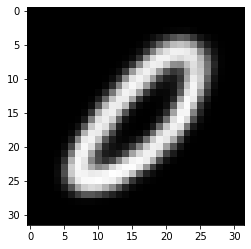

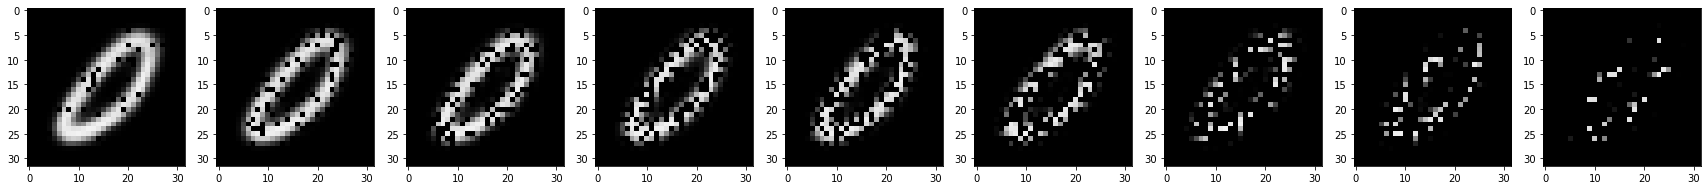

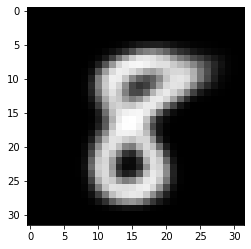

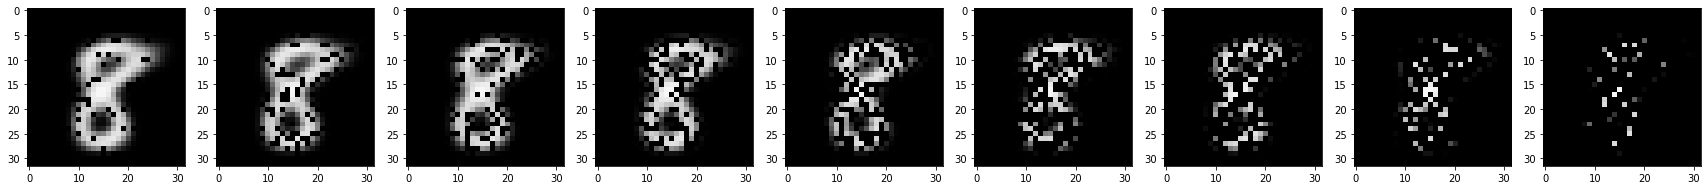

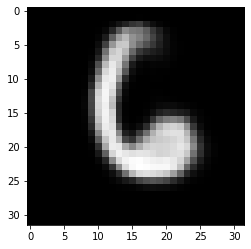

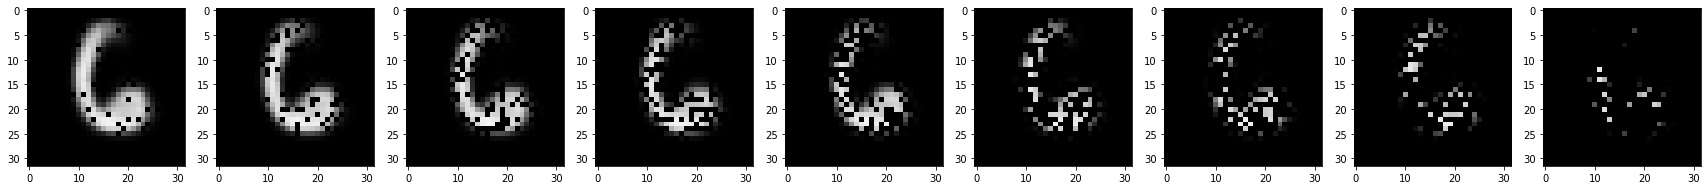

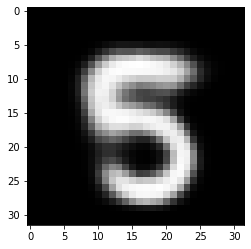

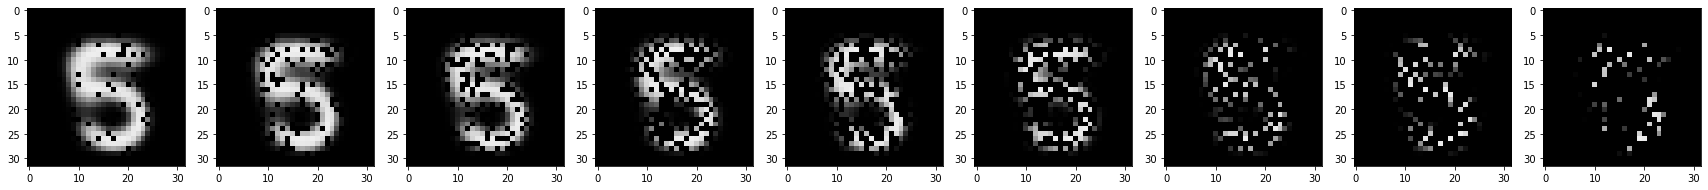

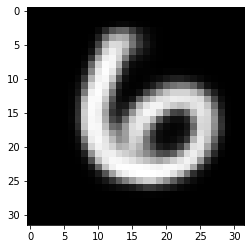

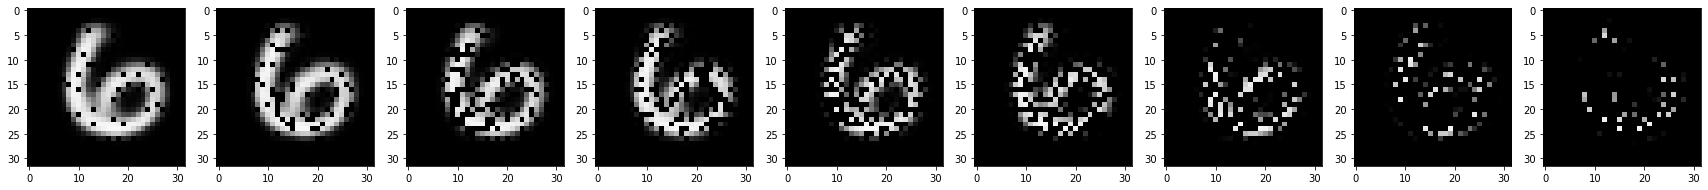

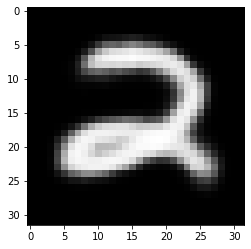

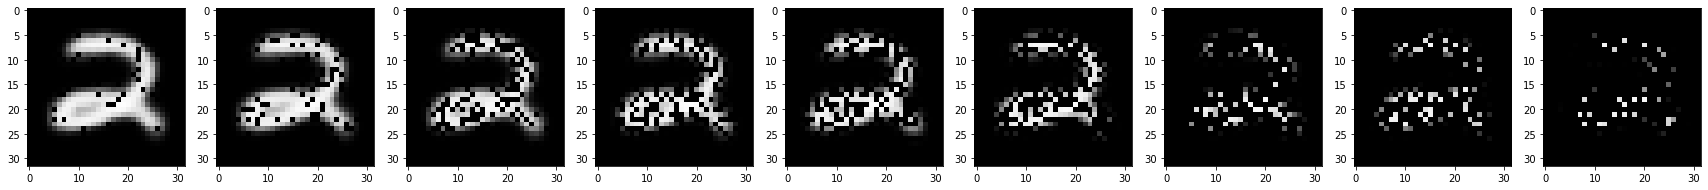

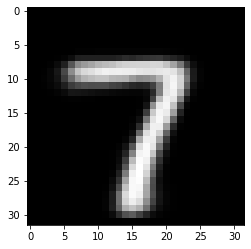

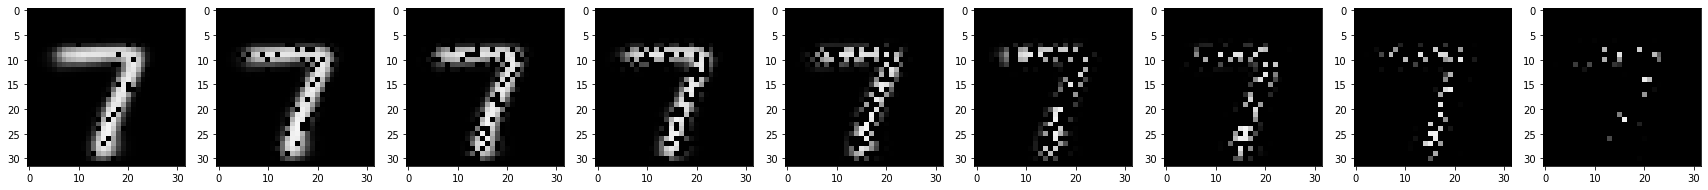

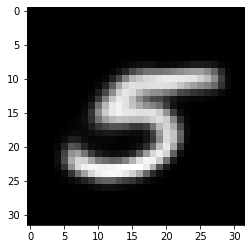

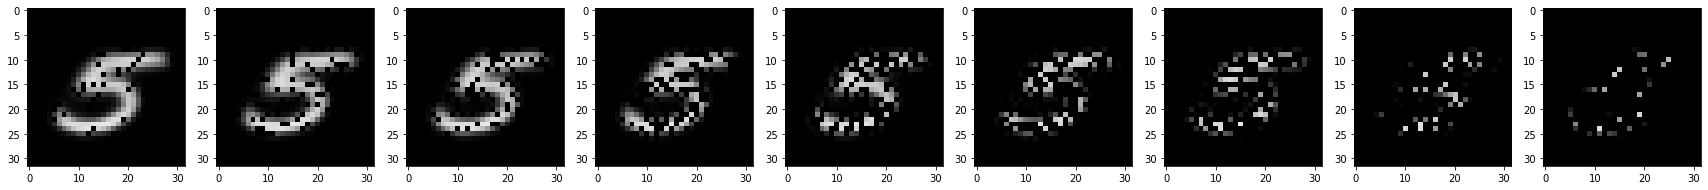

In [28]:
for i_img in range(10):
    img = np.copy(x_monitor[i_img, 0, :, :])

    # show original image
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.show()
    
    # successively set pixels to the mean pixel
    fig, ax = plt.subplots(1, 9, figsize=(30, 300))
    for idx, q in enumerate(np.linspace(0.9, 0.1, 9)):
        img = np.copy(x_monitor[i_img, 0, :, :])
        for i in range(IMG_DIM):
            for j in range(IMG_DIM):
                if np.random.random() > q:
                    img[i, j] = removed_pixel_value
        ax[idx].imshow(img, cmap='gray', interpolation='none', vmin=0, vmax=1)
    plt.show()

## Load data (all methods)

In [27]:
X_train, Y_train, _, T_train = torch.load('./data/MNIST32_train_final.pkl')
_, X_test, Y_test, T_test = pkl.load(open('./output/mnist_monitor_32_10000.pkl', 'rb'))

## Remove randomly (RANDOM)

In [69]:
if method == 'random' or aid is None:
    for i in tqdm(range(60000)):
            X_train[i, 0][np.random.random((32, 32)) < remove_fraction] =  removed_pixel_value
            
    for i in tqdm(range(10000)):
            X_test[i, 0][np.random.random((32, 32)) < remove_fraction] =  removed_pixel_value  

100%|██████████| 10000/10000 [00:00<00:00, 28473.87it/s]


## Remove according to a saliency map (GRAD/INT GRAD/INPUT x GRAD/SMOOTHGRAD)

In [28]:
if method in ['grad','int_grad', 'input_times_grad', 'smoothgrad'] or aid is None:
    for i in tqdm(range(60000)):
        if method == 'grad':
            saliency = util.plain_gradient(model, X_train[i, 0])
        elif method == 'int_grad':
            saliency = util.integrated_gradients(model, X_train[i, 0])
        elif method == 'input_times_grad':
            saliency = util.input_x_gradient(model, X_train[i, 0])
        elif method == 'smoothgrad':
            saliency = util.smooth_grad(model, X_train[i, 0], 0.02, 25)
        saliency = np.abs(saliency)
        if top_or_bottom == 0: # keep bottom, i.e. remove from the top
            quantile = np.quantile(saliency.flatten(), 1-remove_fraction)  
            X_train[i, 0][saliency > quantile] = removed_pixel_value
        else: # keep top, i.e. remove from the bottom
            quantile = np.quantile(saliency.flatten(), remove_fraction)  
            X_train[i, 0][saliency <= quantile] = removed_pixel_value
            
    for i in tqdm(range(10000)):
        if method == 'grad':
            saliency = util.plain_gradient(model, X_test[i, 0])
        elif method == 'int_grad':
            saliency = util.integrated_gradients(model, X_test[i, 0])
        elif method == 'input_times_grad':
            saliency = util.input_x_gradient(model, X_test[i, 0])
        elif method == 'smoothgrad':
            saliency = util.smooth_grad(model, X_test[i, 0], 0.02, 25)
        saliency = np.abs(saliency)
        if top_or_bottom == 0: # keep bottom, i.e. remove from the top
            quantile = np.quantile(saliency.flatten(), 1-remove_fraction)    
            X_test[i, 0][saliency > quantile] = removed_pixel_value
        else: # keep top, i.e. remove from the bottom
            quantile = np.quantile(saliency.flatten(), remove_fraction)    
            X_test[i, 0][saliency <= quantile] = removed_pixel_value

100%|██████████| 10000/10000 [00:17<00:00, 576.48it/s]


## Remove according to the tangent space (TANGENT SPACE)

In [96]:
#remove_fraction = 0.99
#top_or_bottom = 1

In [97]:
if method == 'tangent_space' or aid is None:
    for i in tqdm(range(60000)):
        tpp = util.tangent_space_per_pixel(T_train[i])
        if top_or_bottom == 0: # keep bottom, i.e. remove from the top
            quantile = np.quantile(tpp.flatten(), 1-remove_fraction)    
            X_train[i, 0][tpp > quantile] = removed_pixel_value
        else: # keep top, i.e. remove from the bottom
            quantile = np.quantile(tpp.flatten(), remove_fraction)    
            X_train[i, 0][tpp <= quantile] = removed_pixel_value
        
    for i in tqdm(range(10000)):
        tpp = util.tangent_space_per_pixel(T_test[i]) 
        if top_or_bottom == 0: # keep bottom, i.e. remove from the top
            quantile = np.quantile(tpp.flatten(), 1-remove_fraction)   
            X_test[i, 0][tpp > quantile] = removed_pixel_value
        else: # keep top, i.e. remove from the bottom
            quantile = np.quantile(tpp.flatten(), remove_fraction)   
            X_test[i, 0][tpp <= quantile] = removed_pixel_value

100%|██████████| 10000/10000 [00:11<00:00, 896.17it/s]


## pytorch data interface

In [29]:
trainset = torch.utils.data.TensorDataset(X_train, Y_train)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = torch.utils.data.TensorDataset(X_test, Y_test)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

## visualize training data

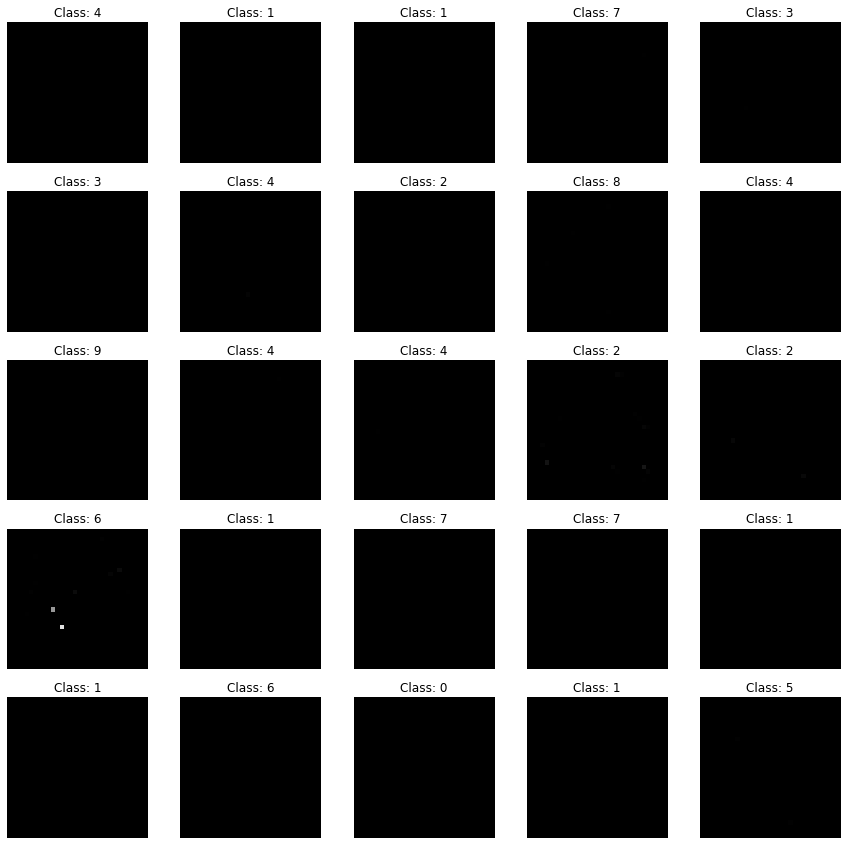

In [30]:
fix, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        img, c = iter(trainloader).__next__()
        axs[i,j].imshow(dcn(img[0, 0, :, :]), cmap='gray', interpolation='none', vmin=0, vmax=1)
        axs[i,j].set_title(f'Class: {c[0]}')
        axs[i,j].axis('off')
plt.show()

## Train LeNet

#### monitor how class gradients evolve during training

In [107]:
model, optimizer = model_and_optimizer()

In [108]:
# decrease the learning rate over time
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [109]:
model.to(device)
ce_loss = torch.nn.CrossEntropyLoss()

for i_epoch in range(30):    
    print(f' --- Epoch {i_epoch} --- ')
    # gradient descent on the dataset
    ce_loss = torch.nn.CrossEntropyLoss()
    model.train()
    train_loss = 0
    train_zero_one_loss = 0
    for img, label in trainloader:
        # take a single gradient step
        img, label = img.to(device), label.to(device)
        pred = model(img)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
    train_zero_one_loss = train_zero_one_loss / len(trainloader.dataset)
    print('Train Error: ', train_zero_one_loss)
    
    util.test(model, testloader, device)
    scheduler.step()

 --- Epoch 0 --- 
Train Error:  0.42923333333333336
Test Error:  0.2909
 --- Epoch 1 --- 
Train Error:  0.3024833333333333
Test Error:  0.2584
 --- Epoch 2 --- 
Train Error:  0.2723
Test Error:  0.229
 --- Epoch 3 --- 
Train Error:  0.25125
Test Error:  0.2175
 --- Epoch 4 --- 
Train Error:  0.23853333333333335
Test Error:  0.2041
 --- Epoch 5 --- 
Train Error:  0.22351666666666667
Test Error:  0.1945
 --- Epoch 6 --- 
Train Error:  0.2129
Test Error:  0.1857
 --- Epoch 7 --- 
Train Error:  0.20336666666666667
Test Error:  0.182
 --- Epoch 8 --- 
Train Error:  0.19695
Test Error:  0.1774
 --- Epoch 9 --- 
Train Error:  0.19093333333333334
Test Error:  0.1707
 --- Epoch 10 --- 
Train Error:  0.17533333333333334
Test Error:  0.1675
 --- Epoch 11 --- 
Train Error:  0.1713
Test Error:  0.1669
 --- Epoch 12 --- 
Train Error:  0.16943333333333332
Test Error:  0.1656
 --- Epoch 13 --- 
Train Error:  0.16771666666666665
Test Error:  0.1642
 --- Epoch 14 --- 
Train Error:  0.16543333333333332
T

In [44]:
#pkl.dump(util.test(model, testloader, device), open(f'./output/mnist-32-roar-{aid}.pkl', 'wb+'))
pkl.dump(util.test(model, testloader, device), open(f'./output/mnist-32-roar-new-{aid}.pkl', 'wb+'))

Test Error:  0.01


In [ ]:
lalala # secret command to interrup the kernel and end the computation

## Gather results

In [4]:
all_methods = ['random', 'grad', 'grad_tangent_space', 'grad_not_tangent_space', 'tangent_space'] 
all_remove_fractions = list(np.arange(0, 1, 0.05))

all_parameter_combinations = list(product(all_methods, all_remove_fractions))

In [5]:
for i in range(100):
    test_error = pkl.load( open(f'output/mnist-32-roar-{i}.pkl', 'rb') )
    all_parameter_combinations[i] = (*all_parameter_combinations[i], test_error)

In [7]:
all_methods = ['input_times_grad', 'random', 'grad', 'int_grad', 'smoothgrad', 'tangent_space'] 
all_remove_fractions = list(np.arange(0, 1, 0.05))
all_top_or_bottom = [0, 1] # 0 is bottom, 1 is top

new_parameter_combinations = list(product(all_methods, all_remove_fractions, all_top_or_bottom))

In [8]:
for i in range(200):
    try:
        test_error = pkl.load( open(f'output/mnist-32-roar-new-{i}.pkl', 'rb') )
        new_parameter_combinations[i] = (*new_parameter_combinations[i], test_error)
    except:
        new_parameter_combinations[i] = (*new_parameter_combinations[i], 0)
        pass

### combined plot

In [12]:
# avoid type-3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

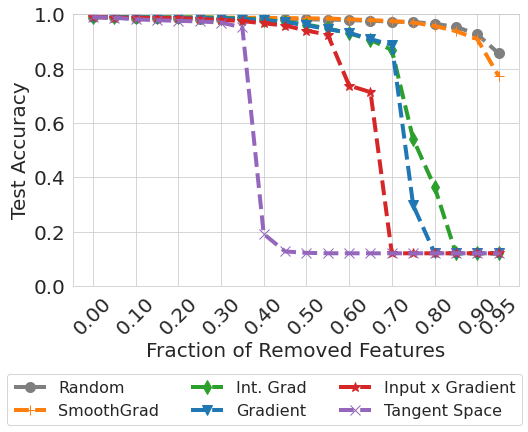

In [13]:
x = list([x[1] for x in all_parameter_combinations if x[0] == 'random'])

sns.set_style('whitegrid')
ax = plt.figure(figsize=(8, 5))
plt.plot(x, [1-x[2] for x in all_parameter_combinations if x[0] == 'random'], "o--", label='Random', lw=4, ms=10, color='tab:gray')
plt.plot(x, [1-x[3] for x in new_parameter_combinations if x[0] == 'smoothgrad' and x[2] == 0], "+--", label='SmoothGrad', lw=4, ms=10, color='tab:orange')
plt.plot(x, [1-x[3] for x in new_parameter_combinations if x[0] == 'int_grad' and x[2] == 0], "d--", label='Int. Grad', lw=4, ms=10, color='tab:green')
plt.plot(x, [1-x[2] for x in all_parameter_combinations if x[0] == 'grad'], "v--", label='Gradient', lw=4, ms=10, color='tab:blue')
plt.plot(x, [1-x[3] for x in new_parameter_combinations if x[0] == 'input_times_grad' and x[2] == 0], "*--", label='Input x Gradient', lw=4, ms=10, color='tab:red')
plt.plot(x, [1-x[2] for x in all_parameter_combinations if x[0] == 'tangent_space'], "x--", label='Tangent Space', lw=4, ms=10, color='tab:purple')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Test Accuracy', fontsize=20)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95], rotation=45)
plt.xlabel('Fraction of Removed Features', fontsize=20)
#plt.title('MNIST-32', fontsize=30)
plt.ylim([0, 1])
plt.legend(fontsize=16, title_fontsize=16, loc="lower center", bbox_to_anchor=(0.43, -0.54), ncol=3)

plt.savefig('figures/mnist-32-roar.pdf', bbox_inches = "tight")
plt.show()